У вас есть ноутбук circle_generator.ipynb Ваша задача сгенерировать изображения кружочков и натренировать нейронную сеть с архитектурой UNet на предмет сегментации кружочков на сгенерированных изображениях.
- Не забываем про разбиение на train/test/validation
- Считать значение лосса и метрики на трейне и тесте во время обучения
- Построить график лосса на трейне и тесте после обучения
- Оценить качество модели на валидации на выбранной метрике.

## 1. Библиотеки

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt


## 2. Генерация данных

#### Определим базовый класс для генерации синтетических данных с нормализацией   

In [2]:
class BaseDataProvider(object):
    """Базовый класс для генерации данных с нормализацией"""
    channels = 3  # RGB изображения (3 канала)
    n_class = 2   # Количество классов: фон и объекты

    def __init__(self, a_min=None, a_max=None):
        """Инициализация с диапазоном нормализации"""
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        """Загрузка и предварительная обработка данных"""
        data, label = self._next_data()  # Получаем сырые данные
        train_data = self._process_data(data)  # Обрабатываем изображение
        labels = self._process_labels(label)  # Обрабатываем маску
        train_data, labels = self._post_process(train_data, labels)  # Постобработка
        nx, ny = train_data.shape[1], train_data.shape[0]
        return (train_data.reshape(1, ny, nx, self.channels), 
                labels.reshape(1, ny, nx, self.n_class))

    def _process_labels(self, label):
        """Преобразование масок в one-hot encoding"""
        if self.n_class == 2:
            labels = np.zeros((*label.shape[:2], 2), dtype=np.float32)
            labels[..., 1] = label.astype(bool)  # Класс объектов
            labels[..., 0] = ~label.astype(bool)  # Класс фона
            return labels
        return label

    def _process_data(self, data):
        """Нормализация изображений в диапазон [0, 1]"""
        return data.astype(np.float32) / 255.0

    def _post_process(self, data, labels):
        """Дополнительная обработка данных"""
        return data, labels

    def __call__(self, n):
        """Генерация n примеров данных"""
        train_data, labels = self._load_data_and_label()
        nx, ny = train_data.shape[1], train_data.shape[2]
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
        X[0], Y[0] = train_data, labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i], Y[i] = train_data, labels
        return X, Y


#### Определим генератор RGB изображений с цветными кругами и прямоугольниками    

In [3]:
class RGBDataProvider(BaseDataProvider):
    """Генератор RGB изображений с цветными объектами"""
    def __init__(self, nx, ny, **kwargs):
        super().__init__()
        self.nx = nx  # Ширина изображения
        self.ny = ny  # Высота изображения
        self.kwargs = kwargs
        self.rectangles = kwargs.get("rectangles", False)
        if self.rectangles:
            self.n_class = 3  # Добавляем класс для прямоугольников

    def _next_data(self):
        """Генерация одного RGB-изображения и маски"""
        return create_rgb_image_and_label(self.nx, self.ny, **self.kwargs)

#### Метод, который создает синтетическое RGB-изображение с объектами и маску сегментации    

In [4]:
def create_rgb_image_and_label(nx, ny, cnt=10, r_min=5, r_max=50, border=92, sigma=20, rectangles=False):
    """
    Создает RGB-изображение с цветными объектами и соответствующую маску
    
    Параметры:
        nx, ny - размеры изображения
        cnt - количество объектов
        r_min, r_max - минимальный и максимальный радиус объектов
        border - отступ от границ для центров объектов
        sigma - уровень шума
        rectangles - флаг для генерации прямоугольников
    """
    image = np.ones((nx, ny, 3)) * 255  # Белый фон [H, W, C]
    label = np.zeros((nx, ny, 3), dtype=bool)  # Маска для 3 классов
    mask = np.zeros((nx, ny), dtype=bool)  # Временная маска

    # Генерация цветных кругов
    for _ in range(cnt):
        a = np.random.randint(border, nx - border)  # x-координата центра
        b = np.random.randint(border, ny - border)  # y-координата центра
        r = np.random.randint(r_min, r_max)  # Радиус
        color = np.random.randint(0, 255, size=3)  # Случайный RGB-цвет

        # Создаем маску круга
        y, x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)
        image[m] = color  # Закрашиваем круг

    label[mask, 1] = 1  # Класс 1 - круги

    # Генерация прямоугольников (если нужно)
    if rectangles:
        rect_mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r = np.random.randint(r_min, r_max)
            color = np.random.randint(0, 255, size=3)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True  # Прямоугольная маска
            rect_mask = np.logical_or(rect_mask, m)
            image[m] = color

        label[rect_mask, 2] = 1  # Класс 2 - прямоугольники
        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))  # Фон

    # Добавляем шум и обрезаем значения
    noise = np.random.normal(scale=sigma, size=(nx, ny, 1))
    image = np.clip(image + noise, 0, 255).astype(np.uint8)

    return image, label[..., 1] if not rectangles else label

## 3. Датасет изображений для сегментации

In [5]:
class CirclesDataset(Dataset):
    """Датасет синтетических RGB изображений для сегментации"""
    def __init__(self, num_samples=1000, image_size=572, cnt=10):
        """
        Инициализация:
            num_samples - количество примеров
            image_size - размер изображения (квадратное)
            cnt - количество объектов на изображении
        """
        self.num_samples = num_samples
        self.image_size = image_size
        self.cnt = cnt
        self.provider = RGBDataProvider(image_size, image_size, cnt=cnt)
    
    def __len__(self):
        """Возвращает количество примеров в датасете"""
        return self.num_samples
    
    def __getitem__(self, idx):
        """Возвращает один пример данных по индексу"""
        x, y = self.provider(1)  # Генерируем 1 пример
        
        # Преобразуем numpy массивы в torch тензоры и меняем порядок размерностей
        image = torch.from_numpy(x[0]).permute(2, 0, 1).float()  # [C, H, W]
        mask = torch.from_numpy(y[0, ..., 1]).unsqueeze(0).float()  # [1, H, W]
        
        return image, mask

## 4. Архитектура U-net

#### Двойной сверточный блок

In [6]:
class DoubleConv(nn.Module):
    """Двойной сверточный блок с нормализацией и ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

#### Блок даунсемплинга

In [7]:
class Down(nn.Module):
    """Шаг downsampling: max pooling + двойная свертка"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

#### Блок асемплинга с конкатенацией

In [8]:
class Up(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        """
        x1 - тензор с предыдущего слоя (меньшего разрешения)
        x2 - тензор с пропускаемого соединения (того же разрешения)
        """
        x1 = self.up(x1)  # Увеличиваем разрешение
        
        # Вычисляем разницу размеров для padding
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        # Добавляем padding для выравнивания размеров
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        
        # Конкатенация с пропускаемым соединением
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)

#### Финальный сверточный слой

In [9]:
class OutConv(nn.Module):
   
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

#### Полная архитектура U-Net для сегментации изображений

In [10]:
class UNet(nn.Module):
    """Архитектура U-Net для сегментации изображений"""
    def __init__(self, n_channels=3, n_classes=1):
        """
        Параметры:
            n_channels - количество входных каналов (3 для RGB)
            n_classes - количество выходных классов
        """
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Encoder (сжатие)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # Decoder (расширение)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder с пропускаемыми соединениями
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        return torch.sigmoid(logits)  # Активация для бинарной сегментации

## 5. Процесс обучения и оценки модели U-Net

In [11]:
class UNetTrainer:
    """Класс для обучения и оценки модели U-Net"""
    def __init__(self, num_epochs, batch_size, image_size, circles_count, num_samples):
        """
        Инициализация:
            num_epochs - количество эпох обучения
            batch_size - размер батча
            image_size - размер изображения
            circles_count - количество объектов на изображении
            num_samples - общее количество примеров
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Параметры
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.image_size = image_size
        self.circles_count = circles_count
        self.num_samples = num_samples
        
        # Инициализация данных
        self._init_datasets()
        
        # Инициализация модели
        self.model = UNet(n_channels=3).to(self.device)
        self.criterion = nn.BCELoss()  # Функция потерь
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)  # Оптимизатор
        
        # Метрики
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def _init_datasets(self):
        """Инициализация датасетов и загрузчиков данных"""
        full_dataset = CirclesDataset(
            num_samples=self.num_samples,
            image_size=self.image_size,
            cnt=self.circles_count
        )
        
        # Разделение на train/val/test
        train_size = int(0.7 * len(full_dataset))
        val_size = int(0.15 * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size])
        
        # Создаем DataLoader'ы
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(
            self.val_dataset, batch_size=self.batch_size)
        self.test_loader = DataLoader(
            self.test_dataset, batch_size=self.batch_size)

    def _calculate_accuracy(self, pred, target):
        """Вычисление точности предсказаний"""
        pred = (pred > 0.5).float()  # Бинаризация с порогом 0.5
        correct = (pred == target).sum().item()
        total = target.numel()
        return correct / total

    def train_epoch(self, epoch):
        """Обучение модели на одной эпохе"""
        self.model.train()
        epoch_loss = 0.0
        epoch_acc = 0.0
        
        for batch_idx, (images, masks) in enumerate(self.train_loader):
            images, masks = images.to(self.device), masks.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Вычисляем метрики
            acc = self._calculate_accuracy(outputs, masks)
            epoch_loss += loss.item()
            epoch_acc += acc
            
            # Выводим информацию о батче
            print(f'Train Epoch [{epoch+1}/{self.num_epochs}] '
                  f'Batch [{batch_idx+1}/{len(self.train_loader)}] '
                  f'train_loss: {loss.item():.4f}, '
                  f'train_acc: {acc:.4f}')
        
        # Средние метрики по эпохе
        avg_loss = epoch_loss / len(self.train_loader)
        avg_acc = epoch_acc / len(self.train_loader)
        self.train_losses.append(avg_loss)
        self.train_accs.append(avg_acc)
        
        return avg_loss, avg_acc

    def validate(self, epoch):
        """Валидация модели"""
        self.model.eval()
        val_loss = 0.0
        val_acc = 0.0
        
        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(self.val_loader):
                images, masks = images.to(self.device), masks.to(self.device)
                outputs = self.model(images)
                
                loss = self.criterion(outputs, masks)
                acc = self._calculate_accuracy(outputs, masks)
                
                val_loss += loss.item()
                val_acc += acc
                
                # Выводим информацию о батче валидации
                print(f'Val Epoch [{epoch+1}/{self.num_epochs}] '
                      f'Batch [{batch_idx+1}/{len(self.val_loader)}] '
                      f'val_loss: {loss.item():.4f}, '
                      f'val_acc: {acc:.4f}')
        
        # Средние метрики по валидации
        avg_loss = val_loss / len(self.val_loader)
        avg_acc = val_acc / len(self.val_loader)
        self.val_losses.append(avg_loss)
        self.val_accs.append(avg_acc)
        
        return avg_loss, avg_acc

    def train(self):
        """Основной цикл обучения"""
        print("Starting training...")
        for epoch in range(self.num_epochs):
            # Одна эпоха обучения и валидации
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate(epoch)
            
            # Выводим сводную информацию по эпохе
            print(f'\nEpoch {epoch+1} Summary:')
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n')

    def evaluate(self):
        """Оценка модели на тестовом наборе"""
        self.model.eval()
        test_loss = 0.0
        test_acc = 0.0
        
        with torch.no_grad():
            for images, masks in self.test_loader:
                images, masks = images.to(self.device), masks.to(self.device)
                outputs = self.model(images)
                
                loss = self.criterion(outputs, masks)
                acc = self._calculate_accuracy(outputs, masks)
                
                test_loss += loss.item()
                test_acc += acc
        
        test_loss /= len(self.test_loader)
        test_acc /= len(self.test_loader)
        
        print(f'\nTest Results:')
        print(f'Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}')
        return test_loss, test_acc

    def plot_metrics(self):
        """Визуализация метрик обучения"""
        plt.figure(figsize=(12, 5))
        
        # График потерь
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train')
        plt.plot(self.val_losses, label='Validation')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # График точности
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Train')
        plt.plot(self.val_accs, label='Validation')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, num_examples=3):
        """Визуализация примеров предсказаний"""
        self.model.eval()
        with torch.no_grad():
            for i, (images, masks) in enumerate(self.test_loader):
                if i >= num_examples:
                    break
                
                images, masks = images.to(self.device), masks.to(self.device)
                outputs = self.model(images)
                preds = (outputs > 0.5).float()  # Бинаризация с порогом 0.5
                
                # Подготовка данных для визуализации
                img_np = images[0].cpu().permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]
                mask_np = masks[0].cpu().squeeze().numpy()
                pred_np = preds[0].cpu().squeeze().numpy()
                
                # Отображение
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(img_np)
                ax[0].set_title('Input (RGB)')
                ax[1].imshow(mask_np, cmap='gray')
                ax[1].set_title('Ground Truth')
                ax[2].imshow(pred_np, cmap='gray')
                ax[2].set_title('Prediction')
                plt.show()

## 6. Запуск обучения

Using device: cuda
Starting training...
Train Epoch [1/10] Batch [1/70] train_loss: 0.7018, train_acc: 0.4288
Train Epoch [1/10] Batch [2/70] train_loss: 0.6329, train_acc: 0.7122
Train Epoch [1/10] Batch [3/70] train_loss: 0.5805, train_acc: 0.8919
Train Epoch [1/10] Batch [4/70] train_loss: 0.5553, train_acc: 0.9469
Train Epoch [1/10] Batch [5/70] train_loss: 0.5321, train_acc: 0.9691
Train Epoch [1/10] Batch [6/70] train_loss: 0.5185, train_acc: 0.9701
Train Epoch [1/10] Batch [7/70] train_loss: 0.5145, train_acc: 0.9796
Train Epoch [1/10] Batch [8/70] train_loss: 0.5170, train_acc: 0.9763
Train Epoch [1/10] Batch [9/70] train_loss: 0.5035, train_acc: 0.9833
Train Epoch [1/10] Batch [10/70] train_loss: 0.4723, train_acc: 0.9875
Train Epoch [1/10] Batch [11/70] train_loss: 0.4717, train_acc: 0.9871
Train Epoch [1/10] Batch [12/70] train_loss: 0.4535, train_acc: 0.9869
Train Epoch [1/10] Batch [13/70] train_loss: 0.4399, train_acc: 0.9928
Train Epoch [1/10] Batch [14/70] train_loss: 0

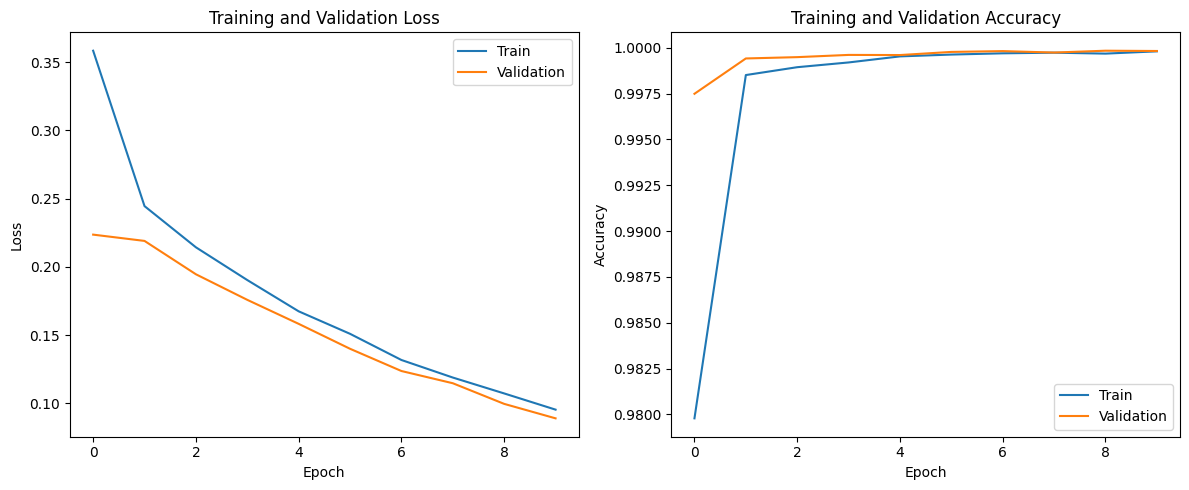


Примеры предсказаний:


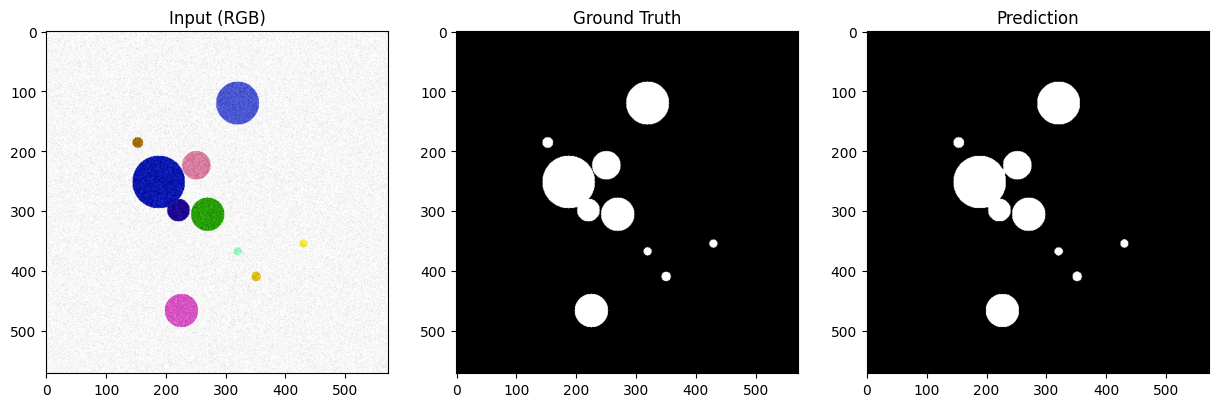

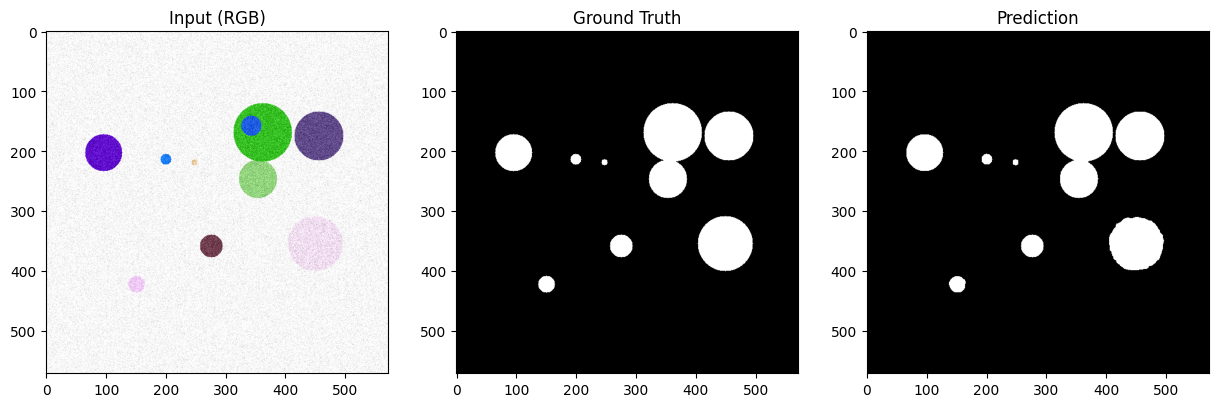

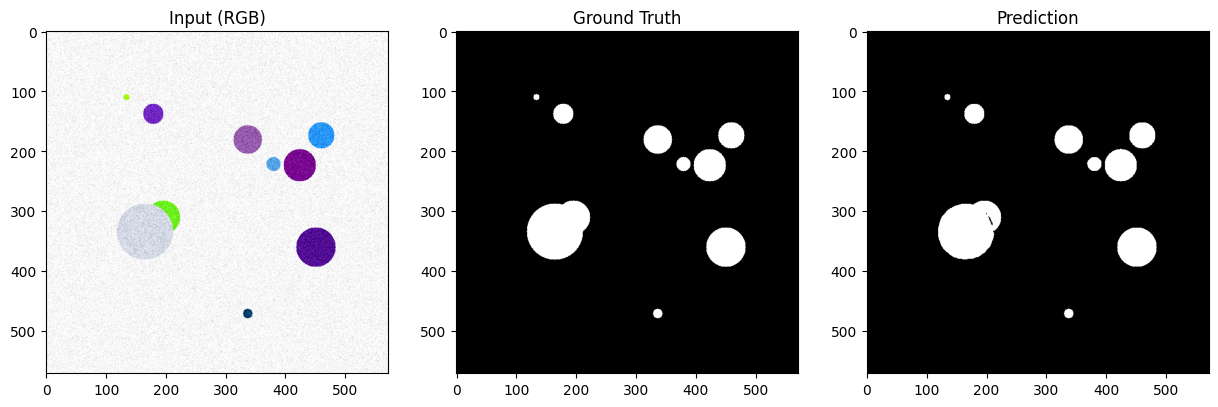

In [12]:
if __name__ == "__main__":
    # Инициализация тренера
    trainer = UNetTrainer(
        num_epochs=10,
        batch_size=2,
        image_size=572,
        circles_count=10,
        num_samples=200
    )
    
    # Обучение модели
    trainer.train()
    
    # Оценка на тестовом наборе
    trainer.evaluate()
    
    # Визуализация метрик
    trainer.plot_metrics()
    
    # Визуализация примеров предсказаний
    print("\nПримеры предсказаний:")
    trainer.plot_predictions()

## 7. Выводы

1. Test accuracy 99.98% - модель показывает практически идеальную точность.

2. Test loss 0.0893 - очень низкое значение функции потерь.
3. Модель успешно обучена и показывает выдающиеся результаты на предоставленных данных. Однако столь высокие показатели требуют дополнительной проверки на предмет возможных проблем с данными.